# Risk Factor -- Statistical Risk Model with PCA




## Overview

We will build a __Statistical Risk Model__ using PCA. Our risk factor model represents the return as:

$$
\textbf{r} = \textbf{B}\textbf{f} + \textbf{s}
$$

where $\textbf{r}$ is a matrix containing the asset returns, $\textbf{B}$ is a matrix representing the factor exposures, $\textbf{f}$ is the matrix of factor returns, and $\textbf{s}$ is the idiosyncratic risk (also known as the company specific risk).

PCA (Principal Components Analysis) is a series of calculations that gives us a new and special basis for our data. 
More practically, PCAs represent the directions of the data that explain a maximum amout of variance (proxy for risk). That means, the lines that capture most risk-related information of the data

In this notebook, we will use real stock data to calculate:

* The Factor Exposures (Factor Betas) $\textbf{B}$
* The Factor Returns $\textbf{f}$
* The Idiosyncratic Risk Matrix $\textbf{S}$
* The Factor Covariance Matrix $\textbf{F}$

We will then combine these quantities to create our Risk Model. 





In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

idx = pd.IndexSlice
plt.style.use("seaborn")

## Market Data
### Load Data
The data we use for this project is end of day data. This contains data for many stocks, but we will systematically extract stocks with high liquidity. That means, we are going to use the universe of most traded stocks.

In [2]:
DATA_STORE = Path('stock_prices.h5')
with pd.HDFStore(DATA_STORE) as store:
    data = store[list(store.keys())[0]].loc[idx[:, '2006':'2016'], :]
data

open       high        low      close     volume
ticker date                                                             
A      2006-01-03  22.786839  22.909642  22.387796  22.855063  3796200.0
       2006-01-04  22.889175  23.080202  22.766372  22.916465  3001300.0
       2006-01-05  22.820951  23.516836  22.820951  23.516836  3458800.0
       2006-01-06  23.537304  23.735153  23.257585  23.639640  4396500.0
       2006-01-09  23.639640  23.741976  23.482724  23.571416  2920500.0
...                      ...        ...        ...        ...        ...
ZUMZ   2016-12-23  20.950000  21.500000  20.950000  21.350000   532292.0
       2016-12-27  21.200000  21.700000  21.200000  21.450000   308004.0
       2016-12-28  21.550000  21.749900  21.325000  21.450000   165827.0
       2016-12-29  21.550000  22.050000  21.400000  21.900000   322108.0
       2016-12-30  21.900000  22.190000  21.600000  21.850000   295429.0

[7531907 rows x 5 columns]

In [3]:
print(f"#Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

#Tickers: 3,186 | # Dates: 2,846


In [4]:
daily_returns = data.groupby('ticker').close.pct_change()
outliers = daily_returns[(daily_returns < daily_returns.quantile(0.00001)) | (daily_returns > daily_returns.quantile(0.99999))]
data = data.drop(outliers.index.unique('ticker'), level='ticker')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7340162 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 308.8+ MB


### Stock Universe

We will select the 500 most-traded stocks prior to the year 2017. We will then compute the dollar volume as the product of the adjusted close price and the adjusted volume:


In [5]:
dv = data.close.mul(data.volume)
selected500Stocks = dv.groupby(level='date').rank(ascending=False).unstack('ticker').dropna(thresh=8*252, axis=1).mean().nsmallest(500)
to_drop = data.index.unique('ticker').difference(selected500Stocks.index)
data = data.drop(to_drop, level='ticker')
data.index.unique('ticker')

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACE', 'ACI', 'ACN', 'ADBE',
       ...
       'XEL', 'XL', 'XLNX', 'XOM', 'XRX', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZMH'],
      dtype='object', name='ticker', length=500)

In [6]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,769


In [7]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1366286 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1366286 non-null  float64
 1   high    1366286 non-null  float64
 2   low     1366286 non-null  float64
 3   close   1366286 non-null  float64
 4   volume  1366286 non-null  float64
dtypes: float64(5)
memory usage: 58.1+ MB


### Return data

In order to develop our risk model, we are going to use a return dataset from our stock universe. To do that, we are going to use the 5 days return of closing prices of our stock universe.

In [8]:
five_days_close_returns = data.close.pct_change(5).dropna().unstack(level='ticker')
five_days_close_returns.dropna(inplace=True)
five_days_close_returns

ticker,A,AAL,AAP,AAPL,ABC,ABT,ACE,ACI,ACN,ADBE,...,XEL,XL,XLNX,XOM,XRX,YHOO,YUM,ZBH,ZION,ZMH
date,,,,,,,,,,,,,,,,,,,,,
2008-05-07,0.050976,-0.145518,-0.025663,0.049669,0.025894,-0.027678,-0.005142,0.108787,-0.005326,0.052293,...,0.020673,-0.030095,0.044112,-0.045665,0.030064,-0.064575,-0.021878,-0.027643,0.033933,-0.027643
2008-05-13,0.012885,-0.130760,-0.015730,0.017679,-0.029953,0.034614,-0.017584,0.021320,-0.021992,0.008447,...,0.000000,-0.053626,0.018554,0.000154,-0.008904,0.032659,0.009120,-0.084623,-0.089384,-0.084623
2008-05-14,0.024567,-0.012262,0.021604,0.020100,-0.010096,0.069019,0.019006,-0.023113,0.019009,0.043323,...,0.008950,0.029255,0.028771,0.016831,-0.003475,0.058502,0.027645,-0.050062,-0.051158,-0.050062
2008-05-15,0.105066,0.082386,0.021226,0.025235,-0.015685,0.070008,0.021548,-0.026114,0.007115,0.050000,...,0.006115,0.073052,0.044961,0.019806,-0.000688,0.058352,0.032725,-0.014185,0.000220,-0.014185
2008-05-16,0.100000,0.101695,0.154326,0.022732,0.000369,0.056586,0.025778,-0.007497,0.014040,0.059413,...,0.015130,0.034734,0.046214,0.043346,0.012649,0.066722,0.027428,0.011688,-0.018275,0.011688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-04-24,0.029806,0.049282,0.023680,0.093948,-0.000924,0.001303,0.007399,-0.116700,-0.009480,0.002855,...,-0.003795,0.011542,-0.073304,0.000700,0.042609,-0.030536,-0.000911,0.113574,-0.024096,0.113574
2014-04-25,-0.004758,0.016949,-0.001738,0.089534,-0.028602,-0.023118,0.006439,-0.119760,-0.005957,-0.037945,...,0.019789,0.005123,-0.083940,-0.000100,0.027122,-0.052226,0.017422,0.104957,-0.040371,0.104957
2014-04-28,-0.017553,-0.014298,0.000329,0.118455,-0.020833,-0.008783,0.006249,-0.124748,-0.008029,-0.060653,...,0.022364,0.007063,-0.107531,0.002378,0.046207,-0.066209,0.022102,0.071156,-0.052266,0.071157


# Statistical Risk Model
It's time to build the risk model. We will be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
### Fit PCA
We implement $\text{fit_pca}$ to fit a PCA model to the returns data

In [9]:
def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    model = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    model.fit(returns)
    return model


### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [10]:
num_factor_exposures = 20
pca = fit_pca(five_days_close_returns, num_factor_exposures, 'full')

pca.components_

array([[ 4.32973104e-02,  7.35479712e-02,  2.39598446e-02, ...,
         2.92679107e-02,  6.39187228e-02,  2.92680646e-02],
       [-2.31302650e-02,  2.08862410e-01,  1.54797604e-05, ...,
         4.22352670e-04,  1.35396989e-01,  4.23309462e-04],
       [-2.27094377e-02, -1.37605404e-01, -4.56646173e-02, ...,
        -1.05822937e-02,  1.64230663e-01, -1.05830584e-02],
       ...,
       [-3.97936138e-03, -9.21198417e-03,  7.43680707e-03, ...,
         7.25632599e-02,  2.00188378e-02,  7.25629415e-02],
       [-1.88767640e-02, -1.37620833e-02,  2.04330419e-02, ...,
        -3.60646580e-02,  4.35577638e-02, -3.60753301e-02],
       [ 2.84647068e-04,  6.65790726e-02,  4.21582696e-03, ...,
        -1.34200428e-02,  2.38443961e-02, -1.34144410e-02]])

We also want to look at the PCA's percent of variance explained by each factor. We must see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

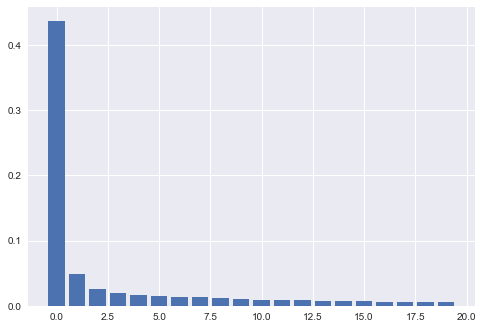

In [11]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)
sns.despine()
plt.show()

## Factor Betas
Next, we implement $\text{factor_betas}$ to get the factor betas from the PCA model.

In [12]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
        
    return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

### View Data
Let's view the factor betas from this model.

In [13]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_days_close_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A,0.043297,-0.023130,-0.022709,0.033351,0.005738,-0.010938,0.020758,-0.007996,-0.007323,-0.019179,0.058699,-0.024224,0.034837,-0.055285,0.005386,-0.026177,-0.040785,-0.003979,-0.018877,0.000285
AAL,0.073548,0.208862,-0.137605,-0.088415,0.378719,-0.102031,0.227984,0.056661,0.113124,0.024678,-0.156891,-0.081108,0.021525,-0.066315,0.035541,-0.030156,-0.036749,-0.009212,-0.013762,0.066579
AAP,0.023960,0.000015,-0.045665,0.007554,0.000276,-0.013772,-0.028865,0.036185,0.044456,0.034564,-0.006072,0.019001,-0.003750,0.057778,-0.029782,0.036260,0.044025,0.007437,0.020433,0.004216
AAPL,0.032911,-0.019125,-0.015592,-0.001819,-0.017283,0.004129,0.016827,-0.007167,0.030934,-0.049464,-0.005401,0.006705,-0.026381,0.023396,0.025553,-0.025653,0.010414,0.050934,0.013141,0.013152
ABC,0.018571,-0.005040,-0.014322,0.025230,0.023792,-0.057634,-0.011788,0.002524,-0.017680,0.005034,0.008833,-0.023646,0.020914,-0.012084,0.004028,0.054537,-0.023878,-0.001812,0.000743,-0.006052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YHOO,0.034187,-0.015576,-0.019939,-0.008207,-0.005365,0.000643,-0.027910,-0.015902,0.032804,-0.000964,0.019531,-0.027534,-0.053817,-0.001075,-0.000724,0.072785,-0.031677,-0.026119,-0.006912,0.006242
YUM,0.027569,0.014743,-0.033725,0.009205,0.004338,-0.006617,-0.016642,0.005737,-0.011489,-0.012255,-0.029280,-0.010997,0.007256,-0.000913,0.009079,0.016624,0.029090,0.052420,0.029698,0.010437
ZBH,0.029268,0.000422,-0.010582,0.032277,0.016454,-0.026529,-0.013782,-0.012395,-0.029608,0.027505,0.049708,0.020310,0.029383,-0.023159,0.000224,0.026706,-0.040671,0.072563,-0.036065,-0.013420
ZION,0.063919,0.135397,0.164231,-0.012681,0.049870,0.099842,-0.065746,0.027750,-0.019484,-0.057604,0.073060,0.015915,-0.035705,-0.082063,-0.004399,0.031253,0.025482,0.020019,0.043558,0.023844


## Factor Returns
Next, we implement $\text{factor_returns}$ to get the factor returns from the PCA model using the five days return data.

In [14]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
        
    return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)


### View Data
Let's see what these factor returns looks like over time.

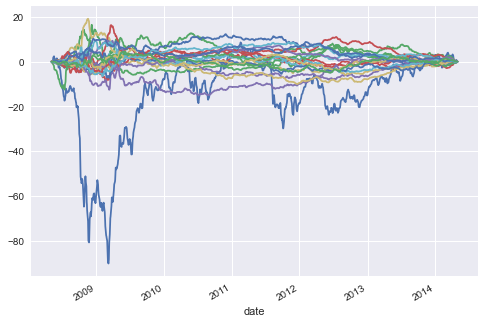

In [15]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_days_close_returns,
    five_days_close_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)
sns.despine()
plt.show()

## Factor Covariance Matrix
Next, we implement $\text{factor_cov_matrix}$ to get the factor covariance matrix.

In [16]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
        
    return np.diag(factor_returns.var(axis = 0, ddof=1))*ann_factor

### View Data

In [17]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[201.42500172,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  22.2277993 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  12.0032298 ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

## Idiosyncratic Variance Matrix
Next, we implement $\text{idiosyncratic_var_matrix}$ to get the idiosyncratic variance matrix.

In [18]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    CommonReturns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals = (returns - CommonReturns)
    
    return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)

In [19]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_days_close_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

ticker,A,AAL,AAP,AAPL,ABC,ABT,ACE,ACI,ACN,ADBE,...,XEL,XL,XLNX,XOM,XRX,YHOO,YUM,ZBH,ZION,ZMH
ticker,,,,,,,,,,,,,,,,,,,,,
A,0.193718,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
AAL,0.000000,0.642205,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
AAP,0.000000,0.000000,0.331879,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
AAPL,0.000000,0.000000,0.000000,0.299469,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
ABC,0.000000,0.000000,0.000000,0.000000,0.111483,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YHOO,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.391756,0.000000,0.000000,0.000000,0.00000
YUM,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.155164,0.000000,0.000000,0.00000
ZBH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.157571,0.000000,0.00000


In [20]:
pd.DataFrame(data=np.diag(risk_model['idiosyncratic_var_matrix'].values), index=list(five_days_close_returns.columns))

,0
A,0.193718
AAL,0.642205
AAP,0.331879
AAPL,0.299469
ABC,0.111483
...,...
YHOO,0.391756
YUM,0.155164
ZBH,0.157571
ZION,0.449586


## Idiosyncratic Variance Vector
Next, we implement $\text{idiosyncratic_var_vector}$ to get the idiosyncratic variance Vector.

In [21]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
        
    return pd.DataFrame(data=np.diag(idiosyncratic_var_matrix.values), index=list(returns.columns))

### View Data

In [22]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_days_close_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
A,0.193718
AAL,0.642205
AAP,0.331879
AAPL,0.299469
ABC,0.111483
...,...
YHOO,0.391756
YUM,0.155164
ZBH,0.157571
ZION,0.449586


In [23]:
risk_model.keys()

dict_keys(['factor_betas', 'factor_returns', 'factor_cov_matrix', 'idiosyncratic_var_matrix', 'idiosyncratic_var_vector'])

## Predict using the Risk Model
Using the data we calculated in the risk model, we are going to implement the function $\text{predict_portfolio_risk}$ to predict the portfolio risk using the formula $$ \sqrt{X^{T}(BFB^{T} + S)X} $$ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [24]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    B = factor_betas
    F = factor_cov_matrix
    S = idiosyncratic_var_matrix
    X = weights
        
    return np.sqrt(np.dot(X.T, np.dot(B, np.dot(F, np.dot(B.T, X)))) + np.dot(X.T, np.dot(S, X))).flatten()[0]
                   

### View Data
Finally, let's see what the portfolio risk would be if we had even weights across all stocks.

In [25]:
all_weights = pd.DataFrame(np.repeat(1/len(five_days_close_returns.columns), len(five_days_close_returns.columns)), five_days_close_returns.columns)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.5841863239221287

With the risk model built from PCA, we have a predicted risk of $58.4\%$.

This risk model will be useful when perform a portfolio optimization where the risk model will be minimized to a certain constraint up to a tolerance. 